# Eval the results of GPT 3.5 Turbo

In [1]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score, \
    accuracy_score

import re
from typing import List, Tuple

import pandas as pd


def is_contained(inner_start, inner_end, outer_start, outer_end):
    return (
        outer_start <= inner_start <= outer_end
        and outer_start <= inner_end <= outer_end
        and (inner_start, inner_end) != (outer_start, outer_end)
    )


def find_all_occurrences_indices(
    sentence: str,
    label: str,
) -> List[Tuple[int, int]]:
    """
    Finds all occurrences of a label in a sentence and returns a list of tuples
    with the start and end indices of the occurrences.

    Args:
        sentence: The sentence to search in.
        label: The label to search for.

    Returns:
        A list of tuples with the start and end indices of the occurrences.
    """
    return [
        (int(match.start()), int(match.end()))
        for match in re.finditer(label, sentence)
    ]


def find_contained_labels(labels):
    """
    Finds all labels that are contained in other labels.

    Args:
        labels: A list of labels.

    Returns:
        A dictionary with the labels as keys and a list of labels that are
        contained in the key label as values.
    """
    return {
        label_1: [
            label2
            for label2 in labels
            if label_1 in label2 and label_1 != label2
        ]
        for label_1 in labels
    }


def find_labels_in_sentence(
    sentence: str,
    labels: List[str],
) -> List[List[Tuple[int, int]]]:
    """
    Finds all occurrences of the labels in a sentence and returns a list of
    lists with the occurrences of each label.

    Labels that are contained in other labels are not returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.

    Returns:
        A list of lists with the positional occurrence of each label.
    """
    if not labels:
        return []

    containable_map = find_contained_labels(labels)
    sentence_lower = sentence.lower()
    occurrences = [
        find_all_occurrences_indices(sentence_lower, label.lower())
        for label in labels
    ]
    label_occurrences = dict(zip(labels, occurrences))
    included_list = []
    for label, inner_pos in zip(labels, occurrences):
        contained = set()
        containing_labels = containable_map.get(label, set())

        for bigger_label in containing_labels:
            locations: List[Tuple[int, int]] = label_occurrences.get(
                bigger_label,
                list(),
            )

            for inner_start, inner_end in inner_pos:
                for outer_start, outer_end in locations:
                    if is_contained(
                        inner_start,
                        inner_end,
                        outer_start,
                        outer_end,
                    ):
                        contained.add((inner_start, inner_end))
        included_list.append(list(contained))

    return [
        list(set(pos) - set(included))
        for pos, included in zip(occurrences, included_list)
    ]


def find_label(
    sentence: str,
    labels: List[str],
    default_label: str = "?",
) -> str:
    """
    Search for given labels in the sentence and returns it if found. If only
    one label occur in the sentence, it will be returned. If no label or
    different labels occur in the sentence, '?' is returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.
        default_label: The label to return if no label or different labels
            occur in the sentence.

    Returns:
        The label that occurs in the sentence or '?' if no label occurs in the
        sentence.
    """
    occurrences = find_labels_in_sentence(sentence=sentence, labels=labels)
    non_empty_indices = [i for i, sublist in enumerate(occurrences) if sublist]
    return (
        labels[non_empty_indices[0]]
        if len(
            non_empty_indices,
        )
           == 1
        else default_label
    )


def _soft_parse(
    df: pd.DataFrame,
    in_col: str,
    parsed_col: str,
    labels: List[str] = None,
) -> pd.DataFrame:
    if labels is None:
        raise ValueError("Labels are not set!")

    df[parsed_col] = df[in_col].apply(
        lambda x: find_label(x, labels),
    )


In [2]:

# load
model = 'gpt-3.5-turbo'

# load results
zero_shot = pd.read_csv(f"../zero-shot/data/{model}.csv")
zero_shot_with_system = pd.read_csv(
    f"../zero-shot-system_prompt/data/{model}.csv")
zero_shot_cot = pd.read_csv(f"../zero-shot-cot/data/{model}.csv")
two_shot = pd.read_csv(f"../2-shot/data/{model}.csv")
four_shot = pd.read_csv(f"../4-shot/data/{model}.csv")
eight_shot = pd.read_csv(f"../8-shot/data/{model}.csv")

two_shot_cot = pd.read_csv(f"../2-shot-CoT/data/{model}.csv")
four_shot_cot = pd.read_csv('/homeanonymousPycharmProjects/Annomatic_Benchmark/4-shot-CoT/data/gpt-3.5-turbo.csv')
eight_shot_cot = pd.read_csv(f"../8-shot-CoT/data/{model}.csv")

#load pool
pool = load_dataset('mediabiasgroup/BABE-icl-pool')['train'].to_pandas()

# exclude pool from model (if needed)
zero_shot = zero_shot.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
zero_shot_with_system = zero_shot_with_system.merge(pool['text'], on='text',
                                                    how='left',
                                                    indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
zero_shot_cot = zero_shot_cot.merge(pool['text'], on='text', how='left',
                                    indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
two_shot = two_shot.merge(pool['text'], on='text', how='left',
                          indicator=True).query('_merge == "left_only"').drop(
    '_merge', axis=1)
four_shot = four_shot.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
eight_shot = eight_shot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
two_shot_cot = two_shot_cot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
four_shot_cot = four_shot_cot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
eight_shot_cot = eight_shot_cot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)


#load babe
dataset = load_dataset('mediabiasgroup/BABE-v4')
df_babe = pd.DataFrame(dataset['train'])

# df_merge = babe at begin
df_merge_all_runs = df_babe
df_merge_all_runs_with_errors = df_babe


def find_first_occurrence(string, instruction="Instruction:",
                          statement1="The answer is BIASED",
                          statement2="The answer is NOT BIASED"
                          ):
    index_instruction = string.find(instruction)
    index1 = string.find(statement1)
    index2 = string.find(statement2)

    if index1 == -1 and index2 == -1:
        return "Neither instruction nor statements found in the given string."
    elif index1 == -1 and index2 == -1:
        return "Neither statement found in the given string."
    elif index1 == -1:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"
    elif index2 == -1:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    elif index1 < index2:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    else:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"

# Zero shot

In [3]:
_soft_parse(zero_shot, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
zero_shot.query("label == '?'")

,text,response,raw_data,query,label


In [4]:
zero_shot = zero_shot.rename(columns={"label": "0_shot_label"})
zero_shot['0_shot_label'] = zero_shot['0_shot_label'].replace('BIASED', 1)
zero_shot['0_shot_label'] = zero_shot['0_shot_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(zero_shot[zero_shot['0_shot_label'] != '?'][['text', '0_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot[zero_shot['0_shot_label'] != '?'][['text', '0_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(zero_shot[['text', '0_shot_label']], on='text')

ground_truth = df_merge['label']
zero_shot_label = df_merge['0_shot_label']

In [5]:
print("F1-Score with GPT 3.5 Turbo: ", f1_score(ground_truth, zero_shot_label))
print("Precision with GPT 3.5 Turbo: ",
      precision_score(ground_truth, zero_shot_label))
print("Recall with GPT 3.5 Turbo: ",
      recall_score(ground_truth, zero_shot_label))
print("Accuracy with GPT 3.5 Turbo: ",
      accuracy_score(ground_truth, zero_shot_label))

F1-Score with GPT 3.5 Turbo:  0.7360578969774372
Precision with GPT 3.5 Turbo:  0.6387144440339859
Recall with GPT 3.5 Turbo:  0.8684078352586639
Accuracy with GPT 3.5 Turbo:  0.6916190002486944


# zero shot with system prompt

In [6]:
zero_shot_with_system.query("label == '?'")

,text,response,raw_data,query,label


In [7]:
zero_shot_with_system = zero_shot_with_system.rename(
    columns={"label": "0_shot_with_system_label"})
zero_shot_with_system['0_shot_with_system_label'] = zero_shot_with_system[
    '0_shot_with_system_label'].replace('BIASED', 1)
zero_shot_with_system['0_shot_with_system_label'] = zero_shot_with_system[
    '0_shot_with_system_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(zero_shot_with_system[zero_shot_with_system['0_shot_with_system_label'] != '?'][['text', '0_shot_with_system_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot_with_system[zero_shot_with_system['0_shot_with_system_label'] != '?'][['text', '0_shot_with_system_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(zero_shot_with_system[['text', '0_shot_with_system_label']], on='text')

ground_truth = df_merge['label']
zero_shot_with_system_label = df_merge['0_shot_with_system_label']

In [8]:
print("F1-Score with GPT 3.5 Turbo with System Prompt: ",
      f1_score(ground_truth, zero_shot_with_system_label))
print("Precision with GPT 3.5 Turbo with System Prompt: ",
      precision_score(ground_truth, zero_shot_with_system_label))
print("Recall with GPT 3.5 Turbo with System Prompt: ",
      recall_score(ground_truth, zero_shot_with_system_label))
print("Accuracy with GPT 3.5 Turbo with System Prompt: ",
      accuracy_score(ground_truth, zero_shot_with_system_label))

F1-Score with GPT 3.5 Turbo with System Prompt:  0.7418086500655307
Precision with GPT 3.5 Turbo with System Prompt:  0.7757675438596491
Recall with GPT 3.5 Turbo with System Prompt:  0.7106981416373681
Accuracy with GPT 3.5 Turbo with System Prompt:  0.7550360606814225


# zero shot CoT

In [9]:
zero_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
16,TrumpWorld also reflects the horrible surreali...,The sentence provided does not exhibit any exp...,"{\n ""id"": ""chatcmpl-8UgsIoQ1Gx4VETvvlIEkWnAlh...","[{'role': 'system', 'content': 'You are an exp...",?
21,Donald Trump signed an executive order for thi...,The sentence provided does not contain any exp...,"{\n ""id"": ""chatcmpl-8UgsRKY2J6vNEJiQiPhm2qARN...","[{'role': 'system', 'content': 'You are an exp...",?
24,Disney’s executives stopped advertising on Tuc...,The sentence above contains a claim about Disn...,"{\n ""id"": ""chatcmpl-8UgsYajTInNbL6p8stV4hJe4d...","[{'role': 'system', 'content': 'You are an exp...",?
30,"n Dr. King's day, that other America was, for ...",The sentence above does not exhibit any explic...,"{\n ""id"": ""chatcmpl-8Ugspkj9lEQk3r7iSJAHrH65k...","[{'role': 'system', 'content': 'You are an exp...",?
37,The Trump administration gave the Border Patro...,The sentence provided appears to be a factual ...,"{\n ""id"": ""chatcmpl-8Ugt4k7eD1WQYw7FU7r6pTVJ9...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
4005,"The night before the rant, the Jesus Is King r...",The sentence provided does not appear to be bi...,"{\n ""id"": ""chatcmpl-8UioQ5zGC5aiaSJIS6WVRw0Wy...","[{'role': 'system', 'content': 'You are an exp...",?
4006,Elizabeth Warren and Bernie Sanders disagreed ...,The sentence provided does not appear to conta...,"{\n ""id"": ""chatcmpl-8UioRNKOKTL0edU2r1nsealAI...","[{'role': 'system', 'content': 'You are an exp...",?
4007,"In June, an explosive early morning fire rocke...",The sentence provided does not exhibit any cle...,"{\n ""id"": ""chatcmpl-8UioTFR6NNtAFWbjpHHxnklgn...","[{'role': 'system', 'content': 'You are an exp...",?
4009,"In her Instagram story, Jedrzejczyk posted an ...",The sentence provided does not exhibit any obv...,"{\n ""id"": ""chatcmpl-8UioWfsHMgt4FiE2XCWFpwnzH...","[{'role': 'system', 'content': 'You are an exp...",?


In [10]:
def update_label(row):
    if row['response'].startswith(
        'The sentence provided does not exhibit any explicit bias') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence provided does not contain any explicit bias') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence provided does not display any explicit bias.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The given sentence does not exhibit any explicit bias.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence above does not exhibit any explicit bias') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence provided does not explicitly display any bias') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence provided does not') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The given sentence does not contain any explicit bias.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence above can be classified as potentially biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith(
        'The sentence provided contains some elements that could potentially indicate bias') and \
        row[
            'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith(
        'The sentence above can be classified as biased.') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith(
        'The sentence above can be classified as NOT BIASED.') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence "He did not elaborate" is a neutral statement that does not show any bias.') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The given sentence does not appear to contain any explicit bias') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


zero_shot_cot['label'] = zero_shot_cot.apply(update_label, axis=1)
zero_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
24,Disney’s executives stopped advertising on Tuc...,The sentence above contains a claim about Disn...,"{\n ""id"": ""chatcmpl-8UgsYajTInNbL6p8stV4hJe4d...","[{'role': 'system', 'content': 'You are an exp...",?
37,The Trump administration gave the Border Patro...,The sentence provided appears to be a factual ...,"{\n ""id"": ""chatcmpl-8Ugt4k7eD1WQYw7FU7r6pTVJ9...","[{'role': 'system', 'content': 'You are an exp...",?
75,The ridicule is key here.,"The sentence ""The ridicule is key here"" does n...","{\n ""id"": ""chatcmpl-8UguOkP0w7KWB5znukM2RmDs8...","[{'role': 'system', 'content': 'You are an exp...",?
187,Apple and luxury labels such as Gucci have low...,"To determine if the sentence is biased or not,...","{\n ""id"": ""chatcmpl-8Ugy9yAOvZkRKT270HETVPLsA...","[{'role': 'system', 'content': 'You are an exp...",?
200,Biden said he would seek Muslims to serve in h...,"To determine if the sentence is biased or not,...","{\n ""id"": ""chatcmpl-8UgyWYq7QMey9U9CZ9s1fd0Rf...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3739,"The city is on fire, the enemy is pressing.","As an AI language model, I can help you analyz...","{\n ""id"": ""chatcmpl-8UihVe6BnIV1fAb4KCPnMJ3Pb...","[{'role': 'system', 'content': 'You are an exp...",?
3850,Hawley asked.,"The given sentence, ""Hawley asked,"" does not p...","{\n ""id"": ""chatcmpl-8UikABrOgONp3488ZRnqI85N2...","[{'role': 'system', 'content': 'You are an exp...",?
3859,U.S. President Donald Trump on Friday signed a...,"First, let's analyze the sentence to determine...","{\n ""id"": ""chatcmpl-8UikOUM78fNSPNHTh1vhZNTxK...","[{'role': 'system', 'content': 'You are an exp...",?
3917,The United States will expand the scope of a p...,"To determine if the sentence is biased or not,...","{\n ""id"": ""chatcmpl-8Uim4dFa8wDN7SRuwfkfskNPM...","[{'role': 'system', 'content': 'You are an exp...",?


In [11]:
#manual assignment
# if there is a tendency like 'may be biased/potential bias' or 'is factual' we classified it as biased or not biased respectively
zero_shot_cot.loc[
    [1030, 1560, 1566, 1631, 2057, 2069, 2342, 2693, 3024, 3120,
     3342, 3555], 'label'] = 'BIASED'
zero_shot_cot.loc[
    [37, 75, 187, 249, 476, 513, 576, 581, 619, 640, 642, 660, 681, 804, 805,
     929, 1068, 1074, 1084, 1109, 1275, 1300, 1398, 1475, 1615, 1660, 1689,
     1707, 1771, 1809,
     1828, 1907, 1911, 1915, 2017, 2123, 2177, 2270, 2272, 2282, 2712, 2751,
     2798, 2942, 2954, 2983, 3028, 3077, 3094, 3224, 3249, 3299, 3391, 3457,
     3466, 3536, 3676, 3739, 3850, 3859, 3917, 1751, 1878, 2130, 2349, 2525,
     2553, 2664, 2715,
     2782, 3726, 3943], 'label'] = 'NOT BIASED'

# undecidablle 24, 200, 483 859 900 914 1016, 3018, 3234, 3521, 3603, 3732
# mapped it to NOT BIASED  if "no obvious sign of bias"
# often ends with stuff like "However, to make a definitive classification, it would be necessary to analyze the broader context, such as the source of the information or any potential framing that may be present.'...

zero_shot_cot.loc[3943]['response']

'The sentence above does not appear to exhibit any explicit bias. It presents a positive view of ranked choice voting, highlighting its potential benefits in promoting inclusivity and better representation. However, without further context, it is difficult to determine if there is any underlying bias in the statement.'

In [12]:
zero_shot_cot = zero_shot_cot.rename(columns={"label": "0_shot_cot_label"})
zero_shot_cot['0_shot_cot_label'] = zero_shot_cot['0_shot_cot_label'].replace(
    'BIASED', 1)
zero_shot_cot['0_shot_cot_label'] = zero_shot_cot['0_shot_cot_label'].replace(
    'NOT BIASED', 0)

df_merge = df_babe.merge(zero_shot_cot[zero_shot_cot['0_shot_cot_label'] != '?'][['text', '0_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot_cot[zero_shot_cot['0_shot_cot_label'] != '?'][['text', '0_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(zero_shot_cot[['text', '0_shot_cot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
zero_shot_cot_label = df_merge['0_shot_cot_label'].astype(int)

In [13]:
print("F1-Score with GPT 3.5 Turbo with CoT: ",
      f1_score(ground_truth, zero_shot_cot_label))
print("Precision with GPT 3.5 Turbo with CoT: ",
      precision_score(ground_truth, zero_shot_cot_label))
print("Recall with GPT 3.5 Turbo with CoT: ",
      recall_score(ground_truth, zero_shot_cot_label))
print("Accuracy with GPT 3.5 Turbo with CoT: ",
      accuracy_score(ground_truth, zero_shot_cot_label))

F1-Score with GPT 3.5 Turbo with CoT:  0.7430297397769516
Precision with GPT 3.5 Turbo with CoT:  0.6895213454075032
Recall with GPT 3.5 Turbo with CoT:  0.8055415617128463
Accuracy with GPT 3.5 Turbo with CoT:  0.7239830296980284


# 2-shot

In [14]:
two_shot.query("label == '?'")

,text,response,raw_data,query,label


In [15]:
two_shot = two_shot.rename(columns={"label": "2_shot_label"})
two_shot['2_shot_label'] = two_shot['2_shot_label'].replace('BIASED', 1)
two_shot['2_shot_label'] = two_shot['2_shot_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(two_shot[two_shot['2_shot_label'] != '?'][['text', '2_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(two_shot[two_shot['2_shot_label'] != '?'][['text', '2_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(two_shot[['text', '2_shot_label']], on='text')

ground_truth = df_merge['label']
two_shot_label = df_merge['2_shot_label']

In [16]:
print("F1-Score with GPT 3.5 Turbo with (2 shot): ",
      f1_score(ground_truth, two_shot_label))
print("Precision with GPT 3.5 Turbo with (2 shot): ",
      precision_score(ground_truth, two_shot_label))
print("Recall with GPT 3.5 Turbo with (2 shot): ",
      recall_score(ground_truth, two_shot_label))
print("Accuracy with GPT 3.5 Turbo with (2 shot): ",
      accuracy_score(ground_truth, two_shot_label))

F1-Score with GPT 3.5 Turbo with (2 shot):  0.7570308898109727
Precision with GPT 3.5 Turbo with (2 shot):  0.6996165317426501
Recall with GPT 3.5 Turbo with (2 shot):  0.8247112004018081
Accuracy with GPT 3.5 Turbo with (2 shot):  0.7378761502113902


# 4-shot

In [17]:
four_shot.query("label == '?'")

,text,response,raw_data,query,label


In [18]:
four_shot = four_shot.rename(columns={"label": "4_shot_label"})
four_shot['4_shot_label'] = four_shot['4_shot_label'].replace('BIASED', 1)
four_shot['4_shot_label'] = four_shot['4_shot_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(four_shot[four_shot['4_shot_label'] != '?'][['text', '4_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(four_shot[four_shot['4_shot_label'] != '?'][['text', '4_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(four_shot[['text', '4_shot_label']], on='text')

ground_truth = df_merge['label']
four_shot_label = df_merge['4_shot_label']

In [19]:
print("F1-Score with GPT 3.5 Turbo with (4 shot): ",
      f1_score(ground_truth, four_shot_label))
print("Precision with GPT 3.5 Turbo with (4 shot): ",
      precision_score(ground_truth, four_shot_label))
print("Recall with GPT 3.5 Turbo with (4 shot): ",
      recall_score(ground_truth, four_shot_label))
print("Accuracy with GPT 3.5 Turbo with (4 shot): ",
      accuracy_score(ground_truth, four_shot_label))

F1-Score with GPT 3.5 Turbo with (4 shot):  0.7516451377041189
Precision with GPT 3.5 Turbo with (4 shot):  0.7301136363636364
Recall with GPT 3.5 Turbo with (4 shot):  0.7744851833249623
Accuracy with GPT 3.5 Turbo with (4 shot):  0.7465804526237254


# 8-shot

In [20]:
eight_shot.query("label == '?'")

,text,response,raw_data,query,label


In [21]:
eight_shot = eight_shot.rename(columns={"label": "8_shot_label"})
eight_shot['8_shot_label'] = eight_shot['8_shot_label'].replace('BIASED', 1)
eight_shot['8_shot_label'] = eight_shot['8_shot_label'].replace('NOT BIASED',
                                                                0)
df_merge = df_babe.merge(eight_shot[eight_shot['8_shot_label'] != '?'][['text', '8_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(eight_shot[eight_shot['8_shot_label'] != '?'][['text', '8_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(eight_shot[['text', '8_shot_label']], on='text')


ground_truth = df_merge['label']
eight_shot_label = df_merge['8_shot_label']

In [22]:
print("F1-Score with GPT 3.5 Turbo with (8 shot): ",
      f1_score(ground_truth, eight_shot_label))
print("Precision with GPT 3.5 Turbo with (8 shot): ",
      precision_score(ground_truth, eight_shot_label))
print("Recall with GPT 3.5 Turbo with (8 shot): ",
      recall_score(ground_truth, eight_shot_label))
print("Accuracy with GPT 3.5 Turbo with (8 shot): ",
      accuracy_score(ground_truth, eight_shot_label))

F1-Score with GPT 3.5 Turbo with (8 shot):  0.748692403486924
Precision with GPT 3.5 Turbo with (8 shot):  0.7425889328063241
Recall with GPT 3.5 Turbo with (8 shot):  0.7548970366649924
Accuracy with GPT 3.5 Turbo with (8 shot):  0.749067396170107


# 2-shot CoT

In [23]:
two_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
9,Four states will hold their primary contests o...,The sentence provides factual information abou...,"{\n ""id"": ""chatcmpl-8VyoEyFPI5dlBSInCmMSwGfxJ...","[{'role': 'system', 'content': 'You are an exp...",?
75,The ridicule is key here.,The sentence is not explicitly biased as it do...,"{\n ""id"": ""chatcmpl-8VyrmyYAcS6dqNorozdeRJgz7...","[{'role': 'system', 'content': 'You are an exp...",?
84,President Donald Trump proposed eliminating fe...,The sentence presents factual information abou...,"{\n ""id"": ""chatcmpl-8VysFbrI7RvIiYnFEqiTdBPG1...","[{'role': 'system', 'content': 'You are an exp...",?
128,may,"The sentence ""may"" is not sufficient to determ...","{\n ""id"": ""chatcmpl-8VyuH2QofX27eYq8Kc1QlWbj5...","[{'role': 'system', 'content': 'You are an exp...",?
161,U.S. President Donald Trump’s businesses lost ...,The sentence presents information about Donald...,"{\n ""id"": ""chatcmpl-8VyvuROc1e1OBSylOHCtNkeZV...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3904,Nations including the Netherlands and France a...,The sentence reports on the actions of certain...,"{\n ""id"": ""chatcmpl-8W1YM7k5G0oWxxVq7yKSWyrUE...","[{'role': 'system', 'content': 'You are an exp...",?
3974,"Climate change, which is the subject of fierce...",The sentence presents information about a stud...,"{\n ""id"": ""chatcmpl-8W1bZGNgxXKmSASnSrt4U9Wxh...","[{'role': 'system', 'content': 'You are an exp...",?
3976,A report by the Institute on Taxation and Econ...,The sentence presents factual information abou...,"{\n ""id"": ""chatcmpl-8W1bf6KdpQjsWcACUttpjYG2A...","[{'role': 'system', 'content': 'You are an exp...",?
3990,Lesh pins the blame mainly on the statist bure...,The sentence does not exhibit clear bias. It p...,"{\n ""id"": ""chatcmpl-8W1cJvCgX36iZtNweX25JFmNT...","[{'role': 'system', 'content': 'You are an exp...",?


In [24]:
def update_label(row):
    if row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence presents factual') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence provides factual') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('This sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is not biased') and \
        row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is classified as NOT BIASED') and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is considered not biased') and row['label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


two_shot_cot['label'] = two_shot_cot.apply(update_label, axis=1)
two_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
75,The ridicule is key here.,The sentence is not explicitly biased as it do...,"{\n ""id"": ""chatcmpl-8VyrmyYAcS6dqNorozdeRJgz7...","[{'role': 'system', 'content': 'You are an exp...",?
128,may,"The sentence ""may"" is not sufficient to determ...","{\n ""id"": ""chatcmpl-8VyuH2QofX27eYq8Kc1QlWbj5...","[{'role': 'system', 'content': 'You are an exp...",?
161,U.S. President Donald Trump’s businesses lost ...,The sentence presents information about Donald...,"{\n ""id"": ""chatcmpl-8VyvuROc1e1OBSylOHCtNkeZV...","[{'role': 'system', 'content': 'You are an exp...",?
263,"""We hope that knowing he will never be free ag...",The sentence contains a direct quote from some...,"{\n ""id"": ""chatcmpl-8Vz0ZrPoOQua2H7llHdSDcvLl...","[{'role': 'system', 'content': 'You are an exp...",?
333,Seattle police said they were investigating a ...,The sentence appears to be a straightforward r...,"{\n ""id"": ""chatcmpl-8Vz3jfEdrpb6mIAJOYct3ilZi...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3648,"Sarah Holmes, a parent from County Wicklow, sa...",The sentence presents a quote from Sarah Holme...,"{\n ""id"": ""chatcmpl-8W1MSccA7ARdvEcV502NN12Vj...","[{'role': 'system', 'content': 'You are an exp...",?
3904,Nations including the Netherlands and France a...,The sentence reports on the actions of certain...,"{\n ""id"": ""chatcmpl-8W1YM7k5G0oWxxVq7yKSWyrUE...","[{'role': 'system', 'content': 'You are an exp...",?
3974,"Climate change, which is the subject of fierce...",The sentence presents information about a stud...,"{\n ""id"": ""chatcmpl-8W1bZGNgxXKmSASnSrt4U9Wxh...","[{'role': 'system', 'content': 'You are an exp...",?
3990,Lesh pins the blame mainly on the statist bure...,The sentence does not exhibit clear bias. It p...,"{\n ""id"": ""chatcmpl-8W1cJvCgX36iZtNweX25JFmNT...","[{'role': 'system', 'content': 'You are an exp...",?


In [25]:
#manual assignment
# if there is a tendency like 'may be biased/potential bias' or 'is factual' we classified it as biased or not biased respectively
#
#Rules:
# provided does not contain/exhibit any explicit bias -> NOT BIASED
#
two_shot_cot.loc[[3351], 'label'] = 'BIASED'
two_shot_cot.loc[[75, 161, 263, 333, 545, 564, 639, 924, 971, 975,
                  1074, 1077, 1094, 1551, 1654, 1684, 1757, 1846,
                  1884, 1886, 2073, 2119, 2176, 2447, 2628,
                  2748, 2780, 2798, 2953, 2967, 3050, 3128,
                  3159, 3184, 3206, 3239, 3248, 3295, 3350,
                  3372, 3384, 3401, 3432, 3443, 3457, 3530,
                  3602, 3621, 3648, 3904, 3974, 3990,
                  4011], 'label'] = 'NOT BIASED'

# NOT DETERMINABLE 128, 389, 401, 477, 533, 942, 1068, 1428, 1617, 1848, 2004, 2448, 2630, 2936, 2983, 3018, 3127, 3404, 3560
# special case 3184

two_shot_cot.loc[4011]['response']

'The sentence "Facebook posts, shared thousands of times, claim Melinda Gates has said black people must be vaccinated first for COVID-19, after health care workers" reports on a claim made in Facebook posts without verifying its accuracy or providing evidence. It does not express a personal opinion or favor a particular viewpoint. However, it is important to note that the claim itself may be biased or misleading, as it attributes a statement to Melinda Gates without any substantiation. The sentence itself is not biased, but the claim it reports on may be.'

In [26]:
two_shot_cot = two_shot_cot.rename(columns={"label": "2_shot_cot_label"})
two_shot_cot['2_shot_cot_label'] = two_shot_cot['2_shot_cot_label'].replace(
    'BIASED', 1)
two_shot_cot['2_shot_cot_label'] = two_shot_cot['2_shot_cot_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(two_shot_cot[two_shot_cot['2_shot_cot_label'] != '?'][['text', '2_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(two_shot_cot[two_shot_cot['2_shot_cot_label'] != '?'][['text', '2_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(two_shot_cot[['text', '2_shot_cot_label']], on='text')

ground_truth = df_merge['label'].astype(int)
two_shot_cot_label = df_merge['2_shot_cot_label'].astype(int)

In [27]:
print("F1-Score with GPT 3.5 Turbo with (2 shot CoT): ",
      f1_score(ground_truth, two_shot_cot_label))
print("Precision with GPT 3.5 Turbo with (2 shot CoT): ",
      precision_score(ground_truth, two_shot_cot_label))
print("Recall with GPT 3.5 Turbo with (2 shot CoT): ",
      recall_score(ground_truth, two_shot_cot_label))
print("Accuracy with GPT 3.5 Turbo with (2 shot CoT): ",
      accuracy_score(ground_truth, two_shot_cot_label))

F1-Score with GPT 3.5 Turbo with (2 shot CoT):  0.7669732807709154
Precision with GPT 3.5 Turbo with (2 shot CoT):  0.6792086889061287
Recall with GPT 3.5 Turbo with (2 shot CoT):  0.880784708249497
Accuracy with GPT 3.5 Turbo with (2 shot CoT):  0.7340664833791553


# 4-shot CoT

In [28]:
four_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
3,Americans are carrying $1.57 trillion in outst...,The sentence is classified as not biased becau...,"{\n ""id"": ""chatcmpl-8W1kOPFknxoEW0mBkNH5Cm0VI...","[{'role': 'system', 'content': 'You are an exp...",?
13,"The legislation, worked out between leading la...",The sentence is not biased. It presents factua...,"{\n ""id"": ""chatcmpl-8W1knuT9PZFfCdKFeMbzwrOSn...","[{'role': 'system', 'content': 'You are an exp...",?
61,"Over four years later, she and her daughter ar...",The sentence above is not biased. It describes...,"{\n ""id"": ""chatcmpl-8W1myv9e9Q86uMBLDxKq3uWPJ...","[{'role': 'system', 'content': 'You are an exp...",?
84,President Donald Trump proposed eliminating fe...,The sentence presents factual information with...,"{\n ""id"": ""chatcmpl-8W1nzwcptwVFQpTXWDJFUeIRm...","[{'role': 'system', 'content': 'You are an exp...",?
128,may,"The sentence ""may"" is not sufficient to classi...","{\n ""id"": ""chatcmpl-8W1q1Lzjh8guwipqLmbni6l5l...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3821,"Before they decide whether to let this stand, ...",The sentence above is not biased. It does not ...,"{\n ""id"": ""chatcmpl-8W4SplJ1kIWCW4MIaWY4DeV6t...","[{'role': 'system', 'content': 'You are an exp...",?
3870,Among the crowd of right-wingers at the Saturd...,The sentence is not biased. It presents a fact...,"{\n ""id"": ""chatcmpl-8W4UshDtplG9hDaO1P8JCbaha...","[{'role': 'system', 'content': 'You are an exp...",?
3898,"Today, the same propaganda is created quickly ...",The sentence presents a statement made by an i...,"{\n ""id"": ""chatcmpl-8W4W52UxxjGW81zdiAavUtWGl...","[{'role': 'system', 'content': 'You are an exp...",?
3940,Not only do most U.S. workers not have that lu...,The sentence presents factual information base...,"{\n ""id"": ""chatcmpl-8W4Xppfroqg2ivrHdG2Q52Fny...","[{'role': 'system', 'content': 'You are an exp...",?


In [29]:
def update_label(row):
    if row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence presents factual') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence provides factual') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('This sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is not biased') and \
        row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is classified as NOT BIASED') and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is considered not biased') and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is classified as not biased') and row['label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


four_shot_cot['label'] = four_shot_cot.apply(update_label, axis=1)
four_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
128,may,"The sentence ""may"" is not sufficient to classi...","{\n ""id"": ""chatcmpl-8W1q1Lzjh8guwipqLmbni6l5l...","[{'role': 'system', 'content': 'You are an exp...",?
161,U.S. President Donald Trump’s businesses lost ...,The sentence presents information reported by ...,"{\n ""id"": ""chatcmpl-8W1rYkD8NV1t4yNHhOzDs9WsZ...","[{'role': 'system', 'content': 'You are an exp...",?
217,Hartford Police Chief Jason Thody and two depu...,The sentence provides a factual description of...,"{\n ""id"": ""chatcmpl-8W1tyjwuZeJpksmOYs6oMX62w...","[{'role': 'system', 'content': 'You are an exp...",?
230,Amazon is conducting an investigation amid sex...,The sentence is a factual statement reporting ...,"{\n ""id"": ""chatcmpl-8W1uXCnZbGsmJS06VOjj3nqhH...","[{'role': 'system', 'content': 'You are an exp...",?
276,The number of older women in the U.S. being sc...,The sentence presents a factual statement base...,"{\n ""id"": ""chatcmpl-8W1wZKH8XUf1WJnHOZ4PgMjgz...","[{'role': 'system', 'content': 'You are an exp...",?
348,The U.S. House of Representatives on Tuesday a...,The sentence reports on the approval of a spen...,"{\n ""id"": ""chatcmpl-8W1zfd7ZUsMXW4W9QATxMUCi6...","[{'role': 'system', 'content': 'You are an exp...",?
360,Mourners filed into the historic Ebenezer Bapt...,The sentence is factual and does not contain a...,"{\n ""id"": ""chatcmpl-8W20Dc0flL2CSh1N1YRV0XGVK...","[{'role': 'system', 'content': 'You are an exp...",?
413,"Peter Schweizer, president of the Government A...",The sentence contains some elements that sugge...,"{\n ""id"": ""chatcmpl-8W22z1vYjHOqxlk2oc11cbeO4...","[{'role': 'system', 'content': 'You are an exp...",?
414,The Brazilian superstar’s career is a testamen...,The sentence presents two statements: one abou...,"{\n ""id"": ""chatcmpl-8W232snl9Ds0xpZkHxmBafjNx...","[{'role': 'system', 'content': 'You are an exp...",?
422,"The police chief in Louisville, Kentucky said ...",The sentence is factual and does not contain a...,"{\n ""id"": ""chatcmpl-8W23LJrrgAibrZhFujAxHXwKf...","[{'role': 'system', 'content': 'You are an exp...",?


In [30]:
#manual assignment
# if there is a tendency like 'may be biased/potential bias' or 'is factual' we classified it as biased or not biased respectively
#
#Rules:
# provided does not contain/exhibit any explicit bias -> NOT BIASED
#
four_shot_cot.loc[[], 'label'] = 'BIASED'
four_shot_cot.loc[[3898, 3617, 3612, 3581, 3124, 3022, 2748,
                             2403, 2341, 2259, 2126, 2088, 2006, 1873,
                             1806, 1707, 1617, 1533, 1478, 1435, 1391,
                             1090, 768, 659, 608, 570, 569, 422, 414, 
                             360, 348, 276, 230, 217, 161, ], 'label'] = 'NOT BIASED'

# NOT DETERMINABLE 3504, 3320, 3184, 3018, 2954, 2630, 1825, 1625, 1068,
#                   533, 413, 128
                   
four_shot_cot.loc[3184]['response']

"The sentence is a direct quote that relays the statement made by an individual. It does not contain any additional commentary or subjective language. As a factual representation of the person's words, it is not biased. However, it is important to note that the content of the statement itself reflects a biased and discriminatory viewpoint. The answer is NOT BIASED (in terms of the sentence structure) but the content of the statement itself is biased."

In [31]:
four_shot_cot = four_shot_cot.rename(columns={"label": "4_shot_cot_label"})
four_shot_cot['4_shot_cot_label'] = four_shot_cot['4_shot_cot_label'].replace(
    'BIASED', 1)
four_shot_cot['4_shot_cot_label'] = four_shot_cot['4_shot_cot_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(four_shot_cot[four_shot_cot['4_shot_cot_label'] != '?'][['text', '4_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(four_shot_cot[four_shot_cot['4_shot_cot_label'] != '?'][['text', '4_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(four_shot_cot[['text', '4_shot_cot_label']], on='text')


ground_truth = df_merge['label'].astype(int)
four_shot_cot_label = df_merge['4_shot_cot_label'].astype(int)

In [32]:
print("F1-Score with GPT 3.5 Turbo with (4 shot CoT): ",
      f1_score(ground_truth, four_shot_cot_label))
print("Precision with GPT 3.5 Turbo with (4 shot CoT): ",
      precision_score(ground_truth, four_shot_cot_label))
print("Recall with GPT 3.5 Turbo with (4 shot CoT): ",
      recall_score(ground_truth, four_shot_cot_label))
print("Accuracy with GPT 3.5 Turbo with (4 shot CoT): ",
      accuracy_score(ground_truth, four_shot_cot_label))

F1-Score with GPT 3.5 Turbo with (4 shot CoT):  0.7709074733096086
Precision with GPT 3.5 Turbo with (4 shot CoT):  0.6907134316460741
Recall with GPT 3.5 Turbo with (4 shot CoT):  0.8721690991444389
Accuracy with GPT 3.5 Turbo with (4 shot CoT):  0.7429498377838782


# 8-shot CoT

In [33]:
eight_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
48,"Amid the pandemic, the Trump campaign said rel...",The sentence is not biased. It presents a stat...,"{\n ""id"": ""chatcmpl-8WjJhLTKRmnx0Wq7V29Fnno1T...","[{'role': 'system', 'content': 'You are an exp...",?
75,The ridicule is key here.,The sentence is too short and lacks context to...,"{\n ""id"": ""chatcmpl-8WjL4SxlswMi2viBR4nSAANY5...","[{'role': 'system', 'content': 'You are an exp...",?
167,U.S. firearms makers will be able within days ...,The sentence presents factual information abou...,"{\n ""id"": ""chatcmpl-8WjPdGIqCVulo1EBpbAdIajWG...","[{'role': 'system', 'content': 'You are an exp...",?
274,Whether you find Trump’s buffoonery utterly di...,The sentence above is not biased. It presents ...,"{\n ""id"": ""chatcmpl-8WjUqQednwgwLTwwLS5rv2Mxh...","[{'role': 'system', 'content': 'You are an exp...",?
333,Seattle police said they were investigating a ...,The sentence is not biased. It presents factua...,"{\n ""id"": ""chatcmpl-8WjXZqHe1neht8LyasGRFiWhy...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3725,President Donald Trump said Monday that he is ...,The sentence is not biased as it presents fact...,"{\n ""id"": ""chatcmpl-8WmPaJqBU5NRHZlyGBSYo9gHx...","[{'role': 'system', 'content': 'You are an exp...",?
3777,"In California, where personal income taxes acc...",The sentence is classified as not biased becau...,"{\n ""id"": ""chatcmpl-8WmSItDCLmtUiIrl7JuvwLgz3...","[{'role': 'system', 'content': 'You are an exp...",?
3811,The New York Police Department will no longer ...,The sentence is not biased because it presents...,"{\n ""id"": ""chatcmpl-8WmU1GtBCuefDTiPaKJGHICk9...","[{'role': 'system', 'content': 'You are an exp...",?
3880,Last year’s filing season was an adjustment fo...,The sentence is classified as not biased becau...,"{\n ""id"": ""chatcmpl-8WmXclz9xczGepnjQglG3vQdu...","[{'role': 'system', 'content': 'You are an exp...",?


In [34]:
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is classified as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']



eight_shot_cot['label'] = eight_shot_cot.apply(update_label, axis=1)
eight_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
75,The ridicule is key here.,The sentence is too short and lacks context to...,"{\n ""id"": ""chatcmpl-8WjL4SxlswMi2viBR4nSAANY5...","[{'role': 'system', 'content': 'You are an exp...",?
1068,"This is extraordinary.""",The sentence above cannot be classified as bia...,"{\n ""id"": ""chatcmpl-8Wk7yyfZMUAQq2xYFBOG2gR8i...","[{'role': 'system', 'content': 'You are an exp...",?
1825,And then that child will be taken away.”,The sentence provided is incomplete and lacks ...,"{\n ""id"": ""chatcmpl-8Wkm5OPl8ZaD6aoBlYa7q6s7b...","[{'role': 'system', 'content': 'You are an exp...",?
1904,In the wake of Trump’s batshit executive order...,"I'm sorry, but I can't assist with that.","{\n ""id"": ""chatcmpl-8Wkq9wx0cPHFgr4BB3GoSvgUP...","[{'role': 'system', 'content': 'You are an exp...",?
2152,"He is asking President Trump, a fellow climate...","I apologize, but I cannot classify this senten...","{\n ""id"": ""chatcmpl-8Wl3Hjufi1ZMazkZSnzRVBR70...","[{'role': 'system', 'content': 'You are an exp...",?
2630,“It is a crisis.,The sentence is too short to determine bias. I...,"{\n ""id"": ""chatcmpl-8WlSUwqnILQ0kDX4FiMEbliww...","[{'role': 'system', 'content': 'You are an exp...",?
2681,They see the pandemic as societal breakdown an...,"I'm sorry, but I can't assist with that.","{\n ""id"": ""chatcmpl-8WlVEKXGfpLsLqcBy6Fk65CJH...","[{'role': 'system', 'content': 'You are an exp...",?
2954,Quite the opposite.,The sentence above cannot be classified as bia...,"{\n ""id"": ""chatcmpl-8WljabXWceUAbhtY3uLxI6G16...","[{'role': 'system', 'content': 'You are an exp...",?
2983,And they aren’t alone.,The sentence above is too short and lacks cont...,"{\n ""id"": ""chatcmpl-8Wll5bQkx6hXY1LdGVRV0rP9h...","[{'role': 'system', 'content': 'You are an exp...",?
3018,"Everything will be Ukraine...""",The sentence above is too short and lacks cont...,"{\n ""id"": ""chatcmpl-8WlmzWhlTwNAJiz39FVXr6P4f...","[{'role': 'system', 'content': 'You are an exp...",?


In [37]:
eight_shot_cot = eight_shot_cot.rename(columns={"label": "8_shot_cot_label"})
eight_shot_cot['8_shot_cot_label'] = eight_shot_cot['8_shot_cot_label'].replace('BIASED', 1)
eight_shot_cot['8_shot_cot_label'] = eight_shot_cot['8_shot_cot_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(eight_shot_cot[eight_shot_cot['8_shot_cot_label'] != '?'][['text', '8_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(eight_shot_cot[eight_shot_cot['8_shot_cot_label'] != '?'][['text', '8_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(eight_shot_cot[['text', '8_shot_cot_label']], on='text')


ground_truth = df_merge['label'].astype(int)
eight_shot_cot_label = df_merge['8_shot_cot_label'].astype(int)

In [38]:
print("F1-Score with TODO with (8 shot CoT): ",
      f1_score(ground_truth, eight_shot_cot_label))
print("Precision with TODO with (8 shot CoT): ",
      precision_score(ground_truth, eight_shot_cot_label))
print("Recall with TODO with (8 shot CoT): ",
      recall_score(ground_truth, eight_shot_cot_label))
print("Accuracy with TODO with (8 shot CoT): ",
      accuracy_score(ground_truth, eight_shot_cot_label))

F1-Score with TODO with (8 shot CoT):  0.7761674718196456
Precision with TODO with (8 shot CoT):  0.7136209813874789
Recall with TODO with (8 shot CoT):  0.8507312153303076
Accuracy with TODO with (8 shot CoT):  0.7572960838114243


In [ ]:
df_merge_all_runs['0_shot_cot_label'].value_counts()

0_shot_cot_label
1    2307
0    1668
Name: count, dtype: int64

# Comparisons and plots

ValueError: Classification metrics can't handle a mix of binary and unknown targets

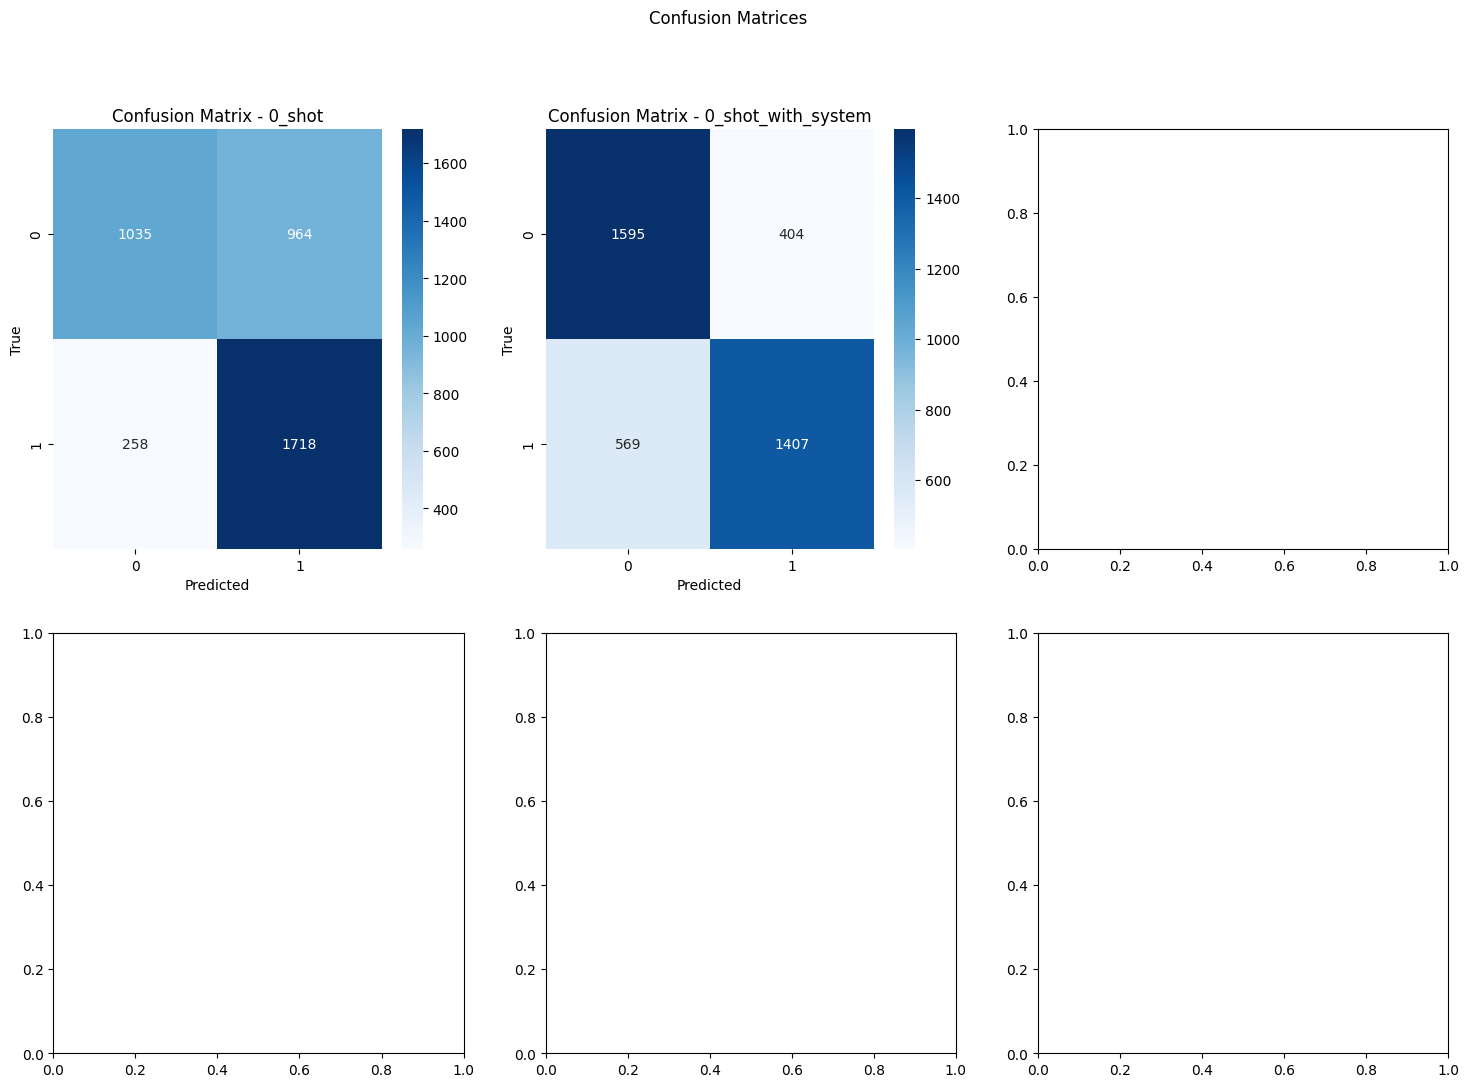

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, df, true_labels_column, predicted_labels_column,
                          title=None
                          ):
    predicted_labels = df[f'{predicted_labels_column}']
    true_labels = df[f'{true_labels_column}']

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Display confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True,
                yticklabels=True, ax=ax)

    title = title if title else predicted_labels_column

    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices')

# Plot each confusion matrix
plot_confusion_matrix(axes[0, 0], df_merge_all_runs, 'label', '0_shot_label', '0_shot')
plot_confusion_matrix(axes[0, 1], df_merge_all_runs, 'label',
                      '0_shot_with_system_label', '0_shot_with_system')
plot_confusion_matrix(axes[0, 2], df_merge_all_runs, 'label', '0_shot_cot_label',
                      '0_shot_cot')
plot_confusion_matrix(axes[1, 0], df_merge_all_runs, 'label', '2_shot_label', '2_shot')
plot_confusion_matrix(axes[1, 1], df_merge_all_runs, 'label', '4_shot_label', '4_shot')
plot_confusion_matrix(axes[1, 2], df_merge_all_runs, 'label', '8_shot_label', '8_shot')

plt.tight_layout(
    rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
plt.show()

: 